This notebook is basically a copy of notebook 12, but with combining the loss with our "Random Layout" Predictor

In [35]:
!pip install -q lion-pytorch

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor, get_random_initial_position
# from lion_pytorch import Lion
from datetime import datetime
import random
from huggingface_hub import hf_hub_download
import timm
from lion_pytorch import Lion
import torch.nn as nn

In [37]:
# Transformations
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [38]:
device = "cpu"

In [39]:
# Load pre-trained ResNet model
random_predictor = timm.create_model('resnet50', pretrained=True)
random_predictor.fc = nn.Linear(random_predictor.fc.in_features, 2)  # Modify the classifier to output 2 classes
random_predictor.to(device)

local_filename = hf_hub_download(repo_id="mowoe/random-layout-classifier", filename="random-layout-classifier.pt")
random_predictor.load_state_dict(torch.load(local_filename, map_location="cpu"))

<All keys matched successfully>

In [40]:
im = Image.open('../combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open('../combined/5373.json', "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]

In [41]:
im.size

(1440, 2560)

In [42]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys():
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes

In [47]:
reduced_segments

[(<PIL.Image.Image image mode=RGBA size=168x168>, (1272, 84)),
 (<PIL.Image.Image image mode=RGBA size=848x142>, (112, 373)),
 (<PIL.Image.Image image mode=RGBA size=888x242>, (112, 571)),
 (<PIL.Image.Image image mode=RGBA size=444x76>, (112, 917)),
 (<PIL.Image.Image image mode=RGBA size=327x168>, (1113, 2224)),
 (<PIL.Image.Image image mode=RGBA size=1440x168>, (0, 2392)),
 (<PIL.Image.Image image mode=RGBA size=1440x84>, (0, 0))]

In [43]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            # initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(1.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        segments_on_canvas.append(background)
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)



        return segments_on_canvas

In [44]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[-4.9740,  1.4086],
        [ 0.2813, -4.2404],
        [ 0.1380,  0.4991],
        [ 2.0552, -0.8634],
        [-2.2309, -9.6325],
        [ 0.0000, 10.8975],
        [ 0.0000, -0.1926]], dtype=torch.float64, requires_grad=True)


In [45]:
msUIo_wbg.coordinates

Parameter containing:
tensor([[-4.9740,  1.4086],
        [ 0.2813, -4.2404],
        [ 0.1380,  0.4991],
        [ 2.0552, -0.8634],
        [-2.2309, -9.6325],
        [ 0.0000, 10.8975],
        [ 0.0000, -0.1926]], dtype=torch.float64, requires_grad=True)

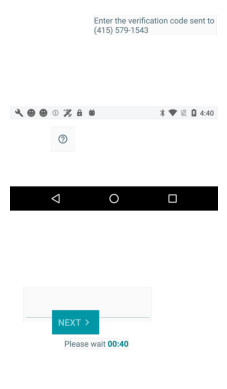

In [24]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

In [25]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao/model123")

In [26]:
#optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)
optimizer = Lion(msUIo_wbg.parameters(), lr=0.0001, weight_decay=1e-2)

In [27]:
random_classifier_criterion = nn.CrossEntropyLoss()

In [28]:
# random_classifier_loss_weight = 0.33
random_classifier_loss_weight = 1.0
random_classifier_target = torch.Tensor([1.0]).to(torch.long)

In [29]:
scores = []
random_losses = []
combined_losses = []
images_for_gif = []

for x in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor["model"](generated_image.unsqueeze(0))
    print(f"Aesthetics Score: {score.detach().item()} (Loss: {1- score.detach().item()})")

    random_classifier_logits = random_predictor(resnet_transform(generated_image.unsqueeze(0)))
    random_loss = random_classifier_criterion(random_classifier_logits,random_classifier_target)
    print(f"Random Layout Loss: {random_loss.detach().item()}")
    random_losses.append(random_loss.detach().item())

    combined_loss = random_classifier_loss_weight * random_loss + (1-random_classifier_loss_weight) * ((1-score)*10)
    combined_losses.append(combined_loss.detach().item())

    print(f"Combined Layout and Aesthetics Loss: {combined_loss.detach().item()}")

    loss = -score
    loss.backward()
    optimizer.step()
    # scheduler.step()

    scores.append(score.detach().item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"output/{x}.png")
    images_for_gif.append(f"output/{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|          | 0/100 [00:00<?, ?it/s]

Aesthetics Score: 0.5817054510116577 (Loss: 0.4182945489883423)
Random Layout Loss: 5.917177677154541
Combined Layout and Aesthetics Loss: 5.917177677154541


  1%|          | 1/100 [00:07<11:46,  7.14s/it]

Aesthetics Score: 0.6212102174758911 (Loss: 0.3787897825241089)
Random Layout Loss: 5.933455944061279
Combined Layout and Aesthetics Loss: 5.933455944061279


  2%|▏         | 2/100 [00:14<12:14,  7.49s/it]

Aesthetics Score: 0.6264922022819519 (Loss: 0.3735077977180481)
Random Layout Loss: 6.366127014160156
Combined Layout and Aesthetics Loss: 6.366127014160156


  3%|▎         | 3/100 [00:22<12:13,  7.56s/it]

Aesthetics Score: 0.6024333834648132 (Loss: 0.39756661653518677)
Random Layout Loss: 6.523390769958496
Combined Layout and Aesthetics Loss: 6.523390769958496


  4%|▍         | 4/100 [00:30<12:04,  7.55s/it]

Aesthetics Score: 0.6417615413665771 (Loss: 0.35823845863342285)
Random Layout Loss: 6.397715091705322
Combined Layout and Aesthetics Loss: 6.397715091705322


  5%|▌         | 5/100 [00:37<12:03,  7.61s/it]

Aesthetics Score: 0.6238563060760498 (Loss: 0.3761436939239502)
Random Layout Loss: 6.583951473236084
Combined Layout and Aesthetics Loss: 6.583951473236084


  6%|▌         | 6/100 [00:45<11:47,  7.53s/it]

Aesthetics Score: 0.6423947811126709 (Loss: 0.3576052188873291)
Random Layout Loss: 6.150977611541748
Combined Layout and Aesthetics Loss: 6.150977611541748


  7%|▋         | 7/100 [00:52<11:45,  7.58s/it]

Aesthetics Score: 0.6182316541671753 (Loss: 0.3817683458328247)
Random Layout Loss: 5.958913326263428
Combined Layout and Aesthetics Loss: 5.958913326263428


  8%|▊         | 8/100 [01:00<11:48,  7.70s/it]

Aesthetics Score: 0.6450389623641968 (Loss: 0.3549610376358032)
Random Layout Loss: 6.0893025398254395
Combined Layout and Aesthetics Loss: 6.0893025398254395


  9%|▉         | 9/100 [01:08<11:45,  7.76s/it]

Aesthetics Score: 0.618170440196991 (Loss: 0.38182955980300903)
Random Layout Loss: 6.481472969055176
Combined Layout and Aesthetics Loss: 6.481472969055176


 10%|█         | 10/100 [01:16<11:46,  7.86s/it]

Aesthetics Score: 0.6448515057563782 (Loss: 0.3551484942436218)
Random Layout Loss: 6.221149444580078
Combined Layout and Aesthetics Loss: 6.221149444580078


 11%|█         | 11/100 [01:24<11:32,  7.78s/it]

Aesthetics Score: 0.6066784858703613 (Loss: 0.39332151412963867)
Random Layout Loss: 6.378675937652588
Combined Layout and Aesthetics Loss: 6.378675937652588


 12%|█▏        | 12/100 [01:32<11:26,  7.80s/it]

Aesthetics Score: 0.6321277022361755 (Loss: 0.36787229776382446)
Random Layout Loss: 6.202783584594727
Combined Layout and Aesthetics Loss: 6.202783584594727


 13%|█▎        | 13/100 [01:40<11:20,  7.82s/it]

Aesthetics Score: 0.6149654388427734 (Loss: 0.38503456115722656)
Random Layout Loss: 6.298046588897705
Combined Layout and Aesthetics Loss: 6.298046588897705


 14%|█▍        | 14/100 [01:47<11:12,  7.82s/it]

Aesthetics Score: 0.6169602274894714 (Loss: 0.38303977251052856)
Random Layout Loss: 6.320669651031494
Combined Layout and Aesthetics Loss: 6.320669651031494


 15%|█▌        | 15/100 [01:55<11:05,  7.83s/it]

Aesthetics Score: 0.5987139940261841 (Loss: 0.4012860059738159)
Random Layout Loss: 6.442827224731445
Combined Layout and Aesthetics Loss: 6.442827224731445


 16%|█▌        | 16/100 [02:03<10:57,  7.83s/it]

Aesthetics Score: 0.6239728331565857 (Loss: 0.3760271668434143)
Random Layout Loss: 6.132024765014648
Combined Layout and Aesthetics Loss: 6.132024765014648


 17%|█▋        | 17/100 [02:11<10:51,  7.85s/it]

Aesthetics Score: 0.5873835682868958 (Loss: 0.41261643171310425)
Random Layout Loss: 6.0676398277282715
Combined Layout and Aesthetics Loss: 6.0676398277282715


 18%|█▊        | 18/100 [02:19<10:43,  7.85s/it]

Aesthetics Score: 0.6217822432518005 (Loss: 0.37821775674819946)
Random Layout Loss: 6.329786777496338
Combined Layout and Aesthetics Loss: 6.329786777496338


 19%|█▉        | 19/100 [02:26<10:30,  7.78s/it]

Aesthetics Score: 0.5940945148468018 (Loss: 0.40590548515319824)
Random Layout Loss: 5.8497161865234375
Combined Layout and Aesthetics Loss: 5.8497161865234375


 20%|██        | 20/100 [02:34<10:26,  7.83s/it]

Aesthetics Score: 0.6172695159912109 (Loss: 0.38273048400878906)
Random Layout Loss: 6.13546895980835
Combined Layout and Aesthetics Loss: 6.13546895980835


 21%|██        | 21/100 [02:43<10:29,  7.97s/it]

Aesthetics Score: 0.6050609946250916 (Loss: 0.39493900537490845)
Random Layout Loss: 5.497252464294434
Combined Layout and Aesthetics Loss: 5.497252464294434


 22%|██▏       | 22/100 [02:51<10:19,  7.95s/it]

Aesthetics Score: 0.6198184490203857 (Loss: 0.38018155097961426)
Random Layout Loss: 6.078115940093994
Combined Layout and Aesthetics Loss: 6.078115940093994


 23%|██▎       | 23/100 [02:59<10:12,  7.96s/it]

Aesthetics Score: 0.6063706874847412 (Loss: 0.3936293125152588)
Random Layout Loss: 6.002077102661133
Combined Layout and Aesthetics Loss: 6.002077102661133


 24%|██▍       | 24/100 [03:07<10:06,  7.98s/it]

Aesthetics Score: 0.6263404488563538 (Loss: 0.37365955114364624)
Random Layout Loss: 6.2758660316467285
Combined Layout and Aesthetics Loss: 6.2758660316467285


 25%|██▌       | 25/100 [03:14<09:46,  7.82s/it]

Aesthetics Score: 0.616378664970398 (Loss: 0.38362133502960205)
Random Layout Loss: 6.354531764984131
Combined Layout and Aesthetics Loss: 6.354531764984131


 26%|██▌       | 26/100 [03:22<09:46,  7.93s/it]

Aesthetics Score: 0.6459030508995056 (Loss: 0.3540969491004944)
Random Layout Loss: 6.410568714141846
Combined Layout and Aesthetics Loss: 6.410568714141846


 27%|██▋       | 27/100 [03:30<09:33,  7.85s/it]

Aesthetics Score: 0.6314173340797424 (Loss: 0.36858266592025757)
Random Layout Loss: 6.3903985023498535
Combined Layout and Aesthetics Loss: 6.3903985023498535


 28%|██▊       | 28/100 [03:38<09:26,  7.87s/it]

Aesthetics Score: 0.6220521926879883 (Loss: 0.3779478073120117)
Random Layout Loss: 6.544811725616455
Combined Layout and Aesthetics Loss: 6.544811725616455


 29%|██▉       | 29/100 [03:46<09:24,  7.95s/it]

Aesthetics Score: 0.628131628036499 (Loss: 0.371868371963501)
Random Layout Loss: 6.597578048706055
Combined Layout and Aesthetics Loss: 6.597578048706055


 30%|███       | 30/100 [03:54<09:14,  7.93s/it]

Aesthetics Score: 0.6098873615264893 (Loss: 0.39011263847351074)
Random Layout Loss: 6.250706672668457
Combined Layout and Aesthetics Loss: 6.250706672668457


 31%|███       | 31/100 [04:02<09:08,  7.94s/it]

Aesthetics Score: 0.6282007694244385 (Loss: 0.3717992305755615)
Random Layout Loss: 6.26576566696167
Combined Layout and Aesthetics Loss: 6.26576566696167


 32%|███▏      | 32/100 [04:10<09:00,  7.95s/it]

Aesthetics Score: 0.6097524762153625 (Loss: 0.39024752378463745)
Random Layout Loss: 6.194605350494385
Combined Layout and Aesthetics Loss: 6.194605350494385


 33%|███▎      | 33/100 [04:18<08:48,  7.89s/it]

Aesthetics Score: 0.6266826391220093 (Loss: 0.3733173608779907)
Random Layout Loss: 6.328847885131836
Combined Layout and Aesthetics Loss: 6.328847885131836


 34%|███▍      | 34/100 [04:26<08:48,  8.01s/it]

Aesthetics Score: 0.6372461318969727 (Loss: 0.36275386810302734)
Random Layout Loss: 6.51625394821167
Combined Layout and Aesthetics Loss: 6.51625394821167


 35%|███▌      | 35/100 [04:33<08:32,  7.88s/it]

Aesthetics Score: 0.6795099973678589 (Loss: 0.3204900026321411)
Random Layout Loss: 6.695711135864258
Combined Layout and Aesthetics Loss: 6.695711135864258


 36%|███▌      | 36/100 [04:42<08:31,  7.99s/it]

Aesthetics Score: 0.6606630086898804 (Loss: 0.33933699131011963)
Random Layout Loss: 7.1160783767700195
Combined Layout and Aesthetics Loss: 7.1160783767700195


 37%|███▋      | 37/100 [04:49<08:18,  7.91s/it]

Aesthetics Score: 0.6585975885391235 (Loss: 0.34140241146087646)
Random Layout Loss: 7.139948844909668
Combined Layout and Aesthetics Loss: 7.139948844909668


 38%|███▊      | 38/100 [04:58<08:18,  8.03s/it]

Aesthetics Score: 0.6346674561500549 (Loss: 0.36533254384994507)
Random Layout Loss: 6.941664695739746
Combined Layout and Aesthetics Loss: 6.941664695739746


 39%|███▉      | 39/100 [05:06<08:08,  8.01s/it]

Aesthetics Score: 0.6420668363571167 (Loss: 0.3579331636428833)
Random Layout Loss: 6.422644138336182
Combined Layout and Aesthetics Loss: 6.422644138336182


 40%|████      | 40/100 [05:14<08:03,  8.06s/it]

Aesthetics Score: 0.6178357005119324 (Loss: 0.3821642994880676)
Random Layout Loss: 6.5299973487854
Combined Layout and Aesthetics Loss: 6.5299973487854


 41%|████      | 41/100 [05:22<07:55,  8.06s/it]

Aesthetics Score: 0.6423327922821045 (Loss: 0.3576672077178955)
Random Layout Loss: 6.518354415893555
Combined Layout and Aesthetics Loss: 6.518354415893555


 42%|████▏     | 42/100 [05:30<07:48,  8.07s/it]

Aesthetics Score: 0.6140329837799072 (Loss: 0.3859670162200928)
Random Layout Loss: 6.668524742126465
Combined Layout and Aesthetics Loss: 6.668524742126465


 43%|████▎     | 43/100 [05:38<07:40,  8.08s/it]

Aesthetics Score: 0.6304992437362671 (Loss: 0.3695007562637329)
Random Layout Loss: 6.7219109535217285
Combined Layout and Aesthetics Loss: 6.7219109535217285


 44%|████▍     | 44/100 [05:46<07:23,  7.93s/it]

Aesthetics Score: 0.6328110694885254 (Loss: 0.3671889305114746)
Random Layout Loss: 6.578462600708008
Combined Layout and Aesthetics Loss: 6.578462600708008


 45%|████▌     | 45/100 [05:53<07:14,  7.89s/it]

Aesthetics Score: 0.642924964427948 (Loss: 0.357075035572052)
Random Layout Loss: 6.6335062980651855
Combined Layout and Aesthetics Loss: 6.6335062980651855


 46%|████▌     | 46/100 [06:01<07:01,  7.80s/it]

Aesthetics Score: 0.5909520983695984 (Loss: 0.4090479016304016)
Random Layout Loss: 7.0836100578308105
Combined Layout and Aesthetics Loss: 7.0836100578308105


 47%|████▋     | 47/100 [06:09<06:56,  7.86s/it]

Aesthetics Score: 0.6152243614196777 (Loss: 0.38477563858032227)
Random Layout Loss: 6.940160274505615
Combined Layout and Aesthetics Loss: 6.940160274505615


 48%|████▊     | 48/100 [06:17<06:55,  7.98s/it]

Aesthetics Score: 0.6319335103034973 (Loss: 0.3680664896965027)
Random Layout Loss: 6.8318257331848145
Combined Layout and Aesthetics Loss: 6.8318257331848145


 49%|████▉     | 49/100 [06:26<06:52,  8.08s/it]

Aesthetics Score: 0.6054103374481201 (Loss: 0.3945896625518799)
Random Layout Loss: 6.832793712615967
Combined Layout and Aesthetics Loss: 6.832793712615967


 50%|█████     | 50/100 [06:34<06:43,  8.08s/it]

Aesthetics Score: 0.5862917900085449 (Loss: 0.4137082099914551)
Random Layout Loss: 6.602778911590576
Combined Layout and Aesthetics Loss: 6.602778911590576


 51%|█████     | 51/100 [06:42<06:36,  8.10s/it]

Aesthetics Score: 0.5975286960601807 (Loss: 0.40247130393981934)
Random Layout Loss: 6.3378071784973145
Combined Layout and Aesthetics Loss: 6.3378071784973145


 52%|█████▏    | 52/100 [06:50<06:29,  8.11s/it]

Aesthetics Score: 0.6076770424842834 (Loss: 0.39232295751571655)
Random Layout Loss: 6.422049045562744
Combined Layout and Aesthetics Loss: 6.422049045562744


 53%|█████▎    | 53/100 [06:58<06:16,  8.02s/it]

Aesthetics Score: 0.6263964772224426 (Loss: 0.3736035227775574)
Random Layout Loss: 6.21369743347168
Combined Layout and Aesthetics Loss: 6.21369743347168


 54%|█████▍    | 54/100 [07:06<06:10,  8.06s/it]

Aesthetics Score: 0.6107782125473022 (Loss: 0.38922178745269775)
Random Layout Loss: 6.204097270965576
Combined Layout and Aesthetics Loss: 6.204097270965576


 55%|█████▌    | 55/100 [07:14<06:03,  8.08s/it]

Aesthetics Score: 0.6364583969116211 (Loss: 0.3635416030883789)
Random Layout Loss: 6.102618217468262
Combined Layout and Aesthetics Loss: 6.102618217468262


 56%|█████▌    | 56/100 [07:22<05:54,  8.06s/it]

Aesthetics Score: 0.6304410696029663 (Loss: 0.3695589303970337)
Random Layout Loss: 6.54450798034668
Combined Layout and Aesthetics Loss: 6.54450798034668


 57%|█████▋    | 57/100 [07:30<05:50,  8.15s/it]

Aesthetics Score: 0.6215697526931763 (Loss: 0.37843024730682373)
Random Layout Loss: 6.233956336975098
Combined Layout and Aesthetics Loss: 6.233956336975098


 58%|█████▊    | 58/100 [07:39<05:45,  8.23s/it]

Aesthetics Score: 0.6318592429161072 (Loss: 0.3681407570838928)
Random Layout Loss: 6.736555576324463
Combined Layout and Aesthetics Loss: 6.736555576324463


 59%|█████▉    | 59/100 [07:47<05:36,  8.20s/it]

Aesthetics Score: 0.6127609610557556 (Loss: 0.3872390389442444)
Random Layout Loss: 6.792719841003418
Combined Layout and Aesthetics Loss: 6.792719841003418


 60%|██████    | 60/100 [07:55<05:25,  8.13s/it]

Aesthetics Score: 0.6406346559524536 (Loss: 0.3593653440475464)
Random Layout Loss: 6.560831546783447
Combined Layout and Aesthetics Loss: 6.560831546783447


 61%|██████    | 61/100 [08:03<05:13,  8.04s/it]

Aesthetics Score: 0.6090543866157532 (Loss: 0.3909456133842468)
Random Layout Loss: 6.837155818939209
Combined Layout and Aesthetics Loss: 6.837155818939209


 62%|██████▏   | 62/100 [08:11<05:05,  8.04s/it]

Aesthetics Score: 0.627974271774292 (Loss: 0.372025728225708)
Random Layout Loss: 6.373381614685059
Combined Layout and Aesthetics Loss: 6.373381614685059


 63%|██████▎   | 63/100 [08:19<04:57,  8.04s/it]

Aesthetics Score: 0.6110830307006836 (Loss: 0.3889169692993164)
Random Layout Loss: 6.57587194442749
Combined Layout and Aesthetics Loss: 6.57587194442749


 64%|██████▍   | 64/100 [08:27<04:50,  8.06s/it]

Aesthetics Score: 0.6379931569099426 (Loss: 0.3620068430900574)
Random Layout Loss: 6.294442176818848
Combined Layout and Aesthetics Loss: 6.294442176818848


 65%|██████▌   | 65/100 [08:35<04:39,  7.98s/it]

Aesthetics Score: 0.604619562625885 (Loss: 0.395380437374115)
Random Layout Loss: 6.40500020980835
Combined Layout and Aesthetics Loss: 6.40500020980835


 66%|██████▌   | 66/100 [08:43<04:29,  7.94s/it]

Aesthetics Score: 0.6393467783927917 (Loss: 0.36065322160720825)
Random Layout Loss: 6.0982346534729
Combined Layout and Aesthetics Loss: 6.0982346534729


 67%|██████▋   | 67/100 [08:50<04:21,  7.91s/it]

Aesthetics Score: 0.615127682685852 (Loss: 0.38487231731414795)
Random Layout Loss: 6.847426891326904
Combined Layout and Aesthetics Loss: 6.847426891326904


 68%|██████▊   | 68/100 [08:58<04:13,  7.93s/it]

Aesthetics Score: 0.6399661302566528 (Loss: 0.36003386974334717)
Random Layout Loss: 6.631686687469482
Combined Layout and Aesthetics Loss: 6.631686687469482


 69%|██████▉   | 69/100 [09:07<04:08,  8.02s/it]

Aesthetics Score: 0.6492477059364319 (Loss: 0.3507522940635681)
Random Layout Loss: 6.849961757659912
Combined Layout and Aesthetics Loss: 6.849961757659912


 70%|███████   | 70/100 [09:15<04:02,  8.09s/it]

Aesthetics Score: 0.6372186541557312 (Loss: 0.3627813458442688)
Random Layout Loss: 6.998339653015137
Combined Layout and Aesthetics Loss: 6.998339653015137


 71%|███████   | 71/100 [09:23<03:54,  8.07s/it]

Aesthetics Score: 0.6233941316604614 (Loss: 0.3766058683395386)
Random Layout Loss: 6.853526592254639
Combined Layout and Aesthetics Loss: 6.853526592254639


 72%|███████▏  | 72/100 [09:31<03:47,  8.11s/it]

Aesthetics Score: 0.6265485286712646 (Loss: 0.37345147132873535)
Random Layout Loss: 6.804309368133545
Combined Layout and Aesthetics Loss: 6.804309368133545


 73%|███████▎  | 73/100 [09:39<03:35,  7.98s/it]

Aesthetics Score: 0.6445517539978027 (Loss: 0.35544824600219727)
Random Layout Loss: 6.859144687652588
Combined Layout and Aesthetics Loss: 6.859144687652588


 74%|███████▍  | 74/100 [09:47<03:28,  8.01s/it]

Aesthetics Score: 0.6541053652763367 (Loss: 0.34589463472366333)
Random Layout Loss: 6.892122268676758
Combined Layout and Aesthetics Loss: 6.892122268676758


 75%|███████▌  | 75/100 [09:55<03:21,  8.05s/it]

Aesthetics Score: 0.6421761512756348 (Loss: 0.35782384872436523)
Random Layout Loss: 6.286938190460205
Combined Layout and Aesthetics Loss: 6.286938190460205


 76%|███████▌  | 76/100 [10:03<03:12,  8.01s/it]

Aesthetics Score: 0.6619607210159302 (Loss: 0.3380392789840698)
Random Layout Loss: 6.568339824676514
Combined Layout and Aesthetics Loss: 6.568339824676514


 77%|███████▋  | 77/100 [10:11<03:02,  7.95s/it]

Aesthetics Score: 0.6181025505065918 (Loss: 0.3818974494934082)
Random Layout Loss: 6.388552665710449
Combined Layout and Aesthetics Loss: 6.388552665710449


 78%|███████▊  | 78/100 [10:19<02:54,  7.94s/it]

Aesthetics Score: 0.6533685326576233 (Loss: 0.3466314673423767)
Random Layout Loss: 6.3470139503479
Combined Layout and Aesthetics Loss: 6.3470139503479


 79%|███████▉  | 79/100 [10:26<02:44,  7.85s/it]

Aesthetics Score: 0.6554437875747681 (Loss: 0.34455621242523193)
Random Layout Loss: 6.800805568695068
Combined Layout and Aesthetics Loss: 6.800805568695068


 80%|████████  | 80/100 [10:34<02:35,  7.79s/it]

Aesthetics Score: 0.6545693874359131 (Loss: 0.3454306125640869)
Random Layout Loss: 6.449512481689453
Combined Layout and Aesthetics Loss: 6.449512481689453


 81%|████████  | 81/100 [10:42<02:28,  7.84s/it]

Aesthetics Score: 0.6269930005073547 (Loss: 0.37300699949264526)
Random Layout Loss: 7.023754119873047
Combined Layout and Aesthetics Loss: 7.023754119873047


 82%|████████▏ | 82/100 [10:50<02:20,  7.80s/it]

Aesthetics Score: 0.6034515500068665 (Loss: 0.39654844999313354)
Random Layout Loss: 6.787905216217041
Combined Layout and Aesthetics Loss: 6.787905216217041


 83%|████████▎ | 83/100 [10:57<02:10,  7.69s/it]

Aesthetics Score: 0.5770367980003357 (Loss: 0.4229632019996643)
Random Layout Loss: 6.542065143585205
Combined Layout and Aesthetics Loss: 6.542065143585205


 84%|████████▍ | 84/100 [11:05<02:04,  7.80s/it]

Aesthetics Score: 0.653752326965332 (Loss: 0.34624767303466797)
Random Layout Loss: 6.849580764770508
Combined Layout and Aesthetics Loss: 6.849580764770508


 85%|████████▌ | 85/100 [11:13<01:57,  7.82s/it]

Aesthetics Score: 0.6178795099258423 (Loss: 0.3821204900741577)
Random Layout Loss: 6.890870094299316
Combined Layout and Aesthetics Loss: 6.890870094299316


 86%|████████▌ | 86/100 [11:21<01:48,  7.77s/it]

Aesthetics Score: 0.6316372752189636 (Loss: 0.3683627247810364)
Random Layout Loss: 6.811663627624512
Combined Layout and Aesthetics Loss: 6.811663627624512


 87%|████████▋ | 87/100 [11:29<01:41,  7.80s/it]

Aesthetics Score: 0.5842412710189819 (Loss: 0.41575872898101807)
Random Layout Loss: 6.548242092132568
Combined Layout and Aesthetics Loss: 6.548242092132568


 88%|████████▊ | 88/100 [11:36<01:34,  7.83s/it]

Aesthetics Score: 0.612265408039093 (Loss: 0.387734591960907)
Random Layout Loss: 6.744845390319824
Combined Layout and Aesthetics Loss: 6.744845390319824


 89%|████████▉ | 89/100 [11:45<01:27,  7.96s/it]

Aesthetics Score: 0.6147874593734741 (Loss: 0.3852125406265259)
Random Layout Loss: 7.010502815246582
Combined Layout and Aesthetics Loss: 7.010502815246582


 90%|█████████ | 90/100 [11:53<01:20,  8.05s/it]

Aesthetics Score: 0.6431556940078735 (Loss: 0.35684430599212646)
Random Layout Loss: 6.700486660003662
Combined Layout and Aesthetics Loss: 6.700486660003662


 91%|█████████ | 91/100 [12:01<01:12,  8.06s/it]

Aesthetics Score: 0.6474258303642273 (Loss: 0.3525741696357727)
Random Layout Loss: 6.726515293121338
Combined Layout and Aesthetics Loss: 6.726515293121338


 92%|█████████▏| 92/100 [12:09<01:04,  8.11s/it]

Aesthetics Score: 0.633720874786377 (Loss: 0.36627912521362305)
Random Layout Loss: 6.566371440887451
Combined Layout and Aesthetics Loss: 6.566371440887451


 93%|█████████▎| 93/100 [12:17<00:55,  7.94s/it]

Aesthetics Score: 0.6104332208633423 (Loss: 0.3895667791366577)
Random Layout Loss: 6.534372329711914
Combined Layout and Aesthetics Loss: 6.534372329711914


 94%|█████████▍| 94/100 [12:25<00:48,  8.01s/it]

Aesthetics Score: 0.6503564715385437 (Loss: 0.3496435284614563)
Random Layout Loss: 6.482652187347412
Combined Layout and Aesthetics Loss: 6.482652187347412


 95%|█████████▌| 95/100 [12:33<00:40,  8.05s/it]

Aesthetics Score: 0.6521592140197754 (Loss: 0.3478407859802246)
Random Layout Loss: 6.901039123535156
Combined Layout and Aesthetics Loss: 6.901039123535156


 96%|█████████▌| 96/100 [12:41<00:32,  8.06s/it]

Aesthetics Score: 0.6389263868331909 (Loss: 0.3610736131668091)
Random Layout Loss: 6.751076698303223
Combined Layout and Aesthetics Loss: 6.751076698303223


 97%|█████████▋| 97/100 [12:49<00:24,  8.07s/it]

Aesthetics Score: 0.6080570816993713 (Loss: 0.39194291830062866)
Random Layout Loss: 6.605864524841309
Combined Layout and Aesthetics Loss: 6.605864524841309


 98%|█████████▊| 98/100 [12:57<00:16,  8.06s/it]

Aesthetics Score: 0.639028787612915 (Loss: 0.36097121238708496)
Random Layout Loss: 6.854550838470459
Combined Layout and Aesthetics Loss: 6.854550838470459


 99%|█████████▉| 99/100 [13:06<00:08,  8.15s/it]

Aesthetics Score: 0.6520819664001465 (Loss: 0.3479180335998535)
Random Layout Loss: 6.605073928833008
Combined Layout and Aesthetics Loss: 6.605073928833008


100%|██████████| 100/100 [13:14<00:00,  7.94s/it]

Final Score: tensor([0.6521], grad_fn=<SelectBackward0>)


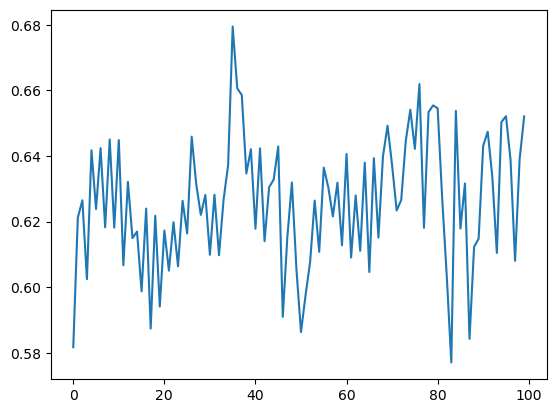

In [33]:
plt.plot(scores)
plt.show()

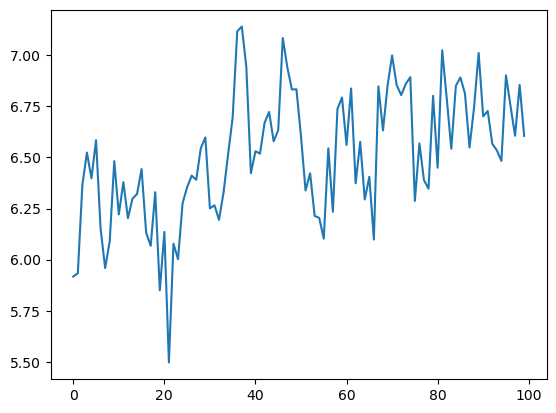

In [34]:
plt.plot(random_losses)
plt.show()

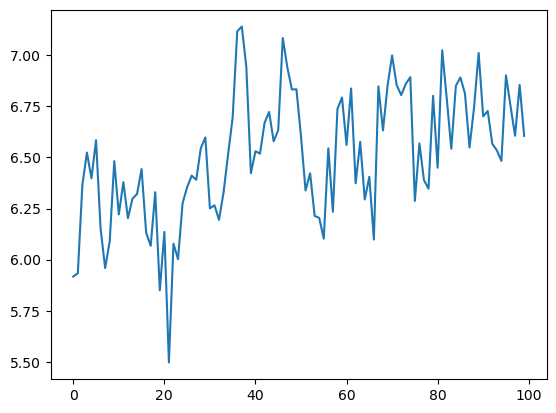

In [32]:
plt.plot(combined_losses)
plt.show()

In [ ]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

It seems like we need a loss to penalise the optimiser pushing the elements out of the canvas.

In [ ]:
msUIo_wbg.coordinates